In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import datetime

%matplotlib inline
plt.style.use('ggplot')

In [6]:
# read data

df = pd.read_pickle('../pkl_data_2/merged_data.pkl')
df.index = df.index.set_levels([df.index.levels[0], pd.to_datetime(df.index.levels[1],format='%Y%m%d'), df.index.levels[2]])
df.sort_index(level=['ann_date'],inplace=True)
df.head()

-30       -29       -28       -27  \
ticker ann_date   quarternum                                           
KEY    1993-10-15 3           0.875159  0.880255  0.876433  0.876433   
       1994-01-21 1           1.138627  1.114401  1.153432  1.150740   
CCK    1995-10-18 3           0.771429  0.757147  0.771429  0.771429   
F      1996-01-31 1           0.937453  0.930725  0.943932  0.946923   
NOVL   1996-02-21 1           0.965263  0.966316  0.949474  0.995789   

                                   -26       -25       -24       -23  \
ticker ann_date   quarternum                                           
KEY    1993-10-15 3           0.896815  0.910828  0.929936  0.908280   
       1994-01-21 1           1.141319  1.119785  1.126514  1.149394   
CCK    1995-10-18 3           0.771429  0.771429  0.771429  0.771429   
F      1996-01-31 1           0.960877  0.964366  0.963369  0.966110   
NOVL   1996-02-21 1           0.965263  0.972632  0.980000  0.991579   

                                   -22       -21  ...  ern_date  \
ticker ann_date   quarternum                      ...             
KEY    1993-10-15 3           0.942675  0.960510  ...  19930930   
       1994-01-21 1           1.177658  1.183042  ...  19931231   
CCK    1995-10-18 3           0.785719  0.828571  ...  19950930   
F      1996-01-31 1           0.948168  0.959382  ...  19951231   
NOVL   1996-02-21 1           0.970526  0.983158  ...  19960131   

                              actual_ern_value  median_surprise  \
ticker ann_date   quarternum                                      
KEY    1993-10-15 3                       0.97              NaN   
       1994-01-21 1                       1.01              NaN   
CCK    1995-10-18 3                       0.38         6.717514   
F      1996-01-31 1                       0.29        19.014636   
NOVL   1996-02-21 1                       0.17              NaN   

                              mean_surprise  forecast_skew  forecast_kurt  \
ticker ann_date   quarternum                                                
KEY    1993-10-15 3                     NaN            NaN            NaN   
       1994-01-21 1                     NaN            NaN            NaN   
CCK    1995-10-18 3                6.717514            0.0       0.707107   
F      1996-01-31 1               19.014636            0.0       0.000000   
NOVL   1996-02-21 1                     NaN            NaN            NaN   

                                   std  filled_std  forecast_count  \
ticker ann_date   quarternum                                         
KEY    1993-10-15 3                NaN         NaN             1.0   
       1994-01-21 1                NaN         NaN             1.0   
CCK    1995-10-18 3           0.056569    0.056569             2.0   
F      1996-01-31 1                NaN    0.008415             1.0   
NOVL   1996-02-21 1                NaN         NaN             1.0   

                              forecast_range  
ticker ann_date   quarternum                  
KEY    1993-10-15 3                     0.00  
       1994-01-21 1                     0.00  
CCK    1995-10-18 3                     0.08  
F      1996-01-31 1                     0.00  
NOVL   1996-02-21 1                     0.00  

[5 rows x 72 columns]

In [7]:
df.index

MultiIndex([( 'KEY', '1993-10-15', 3),
            ( 'KEY', '1994-01-21', 1),
            ( 'CCK', '1995-10-18', 3),
            (   'F', '1996-01-31', 1),
            ('NOVL', '1996-02-21', 1),
            ( 'IBM', '1996-04-17', 2),
            ( 'IBM', '1996-07-25', 2),
            ('AMAT', '1996-08-13', 3),
            ( 'IBM', '1997-01-21', 1),
            ( 'FLR', '1997-05-21', 2),
            ...
            ( 'CNX', '2016-11-01', 3),
            ( 'EMR', '2016-11-01', 3),
            ( 'OKE', '2016-11-01', 3),
            ('EQIX', '2016-11-02', 3),
            ( 'EOG', '2016-11-03', 3),
            ( 'DUK', '2016-11-04', 3),
            ( 'HUM', '2016-11-04', 3),
            ('MCHP', '2016-11-07', 3),
            ( 'CVH', '2016-11-08', 3),
            ( 'MDT', '2016-11-22', 3)],
           names=['ticker', 'ann_date', 'quarternum'], length=833)

In [8]:
# build target variable

q_10 = df[10].quantile(0.1)
q_90 = df[10].quantile(0.9)
t = lambda x: 0 if (x>q_10 and x<q_90) else 1
df['y'] = [t(df[10][i]) for i in range(len(df[10]))]

print('target variable y has',df['y'].value_counts()[0],'occurences of 0 and',df['y'].value_counts()[1],'occurences of 1')

target variable y has 665 occurences of 0 and 168 occurences of 1


In [9]:
# types of training datasets 

#type_1 = 
type_2 = ['forecast_count','std','forecast_range','actual_ern_value','y']

In [10]:
# some useful functions

def tq(year):
    
    # obtains available quarter for that year
    
    t = df.iloc[df.index.get_level_values('ann_date') <= str(year)+'-12-31']
    t = t.iloc[t.index.get_level_values('ann_date') >= str(year)+'-01-01']
    return t.index.get_level_values('quarternum').tolist()

def _idx(year,tested_quater):
    
    # idx is the test set size <=> number of earnings in this year for this tested_quarter
    
    t = df.iloc[df.index.get_level_values('ann_date') <= str(year)+'-12-31']
    t = t.iloc[t.index.get_level_values('ann_date') >= str(year)+'-01-01']
    return t.iloc[t.index.get_level_values('quarternum') == tested_quarter].shape[0]

In [11]:
# pipeline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    #
    # selects features from df
    #
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]
        
    
class QuarterSelector(BaseEstimator, TransformerMixin):
    #
    # selects all data available on or before year, tested quarter from df
    #
    def __init__(self, year, tested_quarter):
        self.year = year
        self.tested_quarter = tested_quarter
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        t = X.iloc[df.index.get_level_values('ann_date') <= str(self.year)+'-12-31']
        fdate = t.iloc[t.index.get_level_values('ann_date') >= str(self.year)+'-01-01']
        fdate = fdate.iloc[fdate.index.get_level_values('quarternum') == self.tested_quarter]
        fdate = fdate.index.get_level_values('ann_date')[-1]
        
        return t.iloc[t.index.get_level_values('ann_date') <= fdate]
        
    
class TrainSelector(BaseEstimator, TransformerMixin):
    #
    # selects training data
    #
    def __init__(self, year, tested_quarter):
        self.year = year
        self.tested_quarter = tested_quarter
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        idx = _idx(self.year,self.tested_quarter)
        return X.iloc[:-idx,:]
    
class TestSelector(BaseEstimator, TransformerMixin):
    #
    # selects training data
    #
    def __init__(self, year, tested_quarter):
        self.year = year
        self.tested_quarter = tested_quarter
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        idx = _idx(self.year,self.tested_quarter)
        return X.iloc[-idx:,:]
    
def run(df,_type,year,tested_quarter,SGDargs):
    
    
    if _type == '1':
        
        train_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('train_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_1)),
                ('imputer',SimpleImputer(strategy="median"))])
                #('sgd',SGDClassifier(**SGDargs))])
        
        test_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('test_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_1)),
                ('imputer',SimpleImputer(strategy="median"))])
    else:
        train_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('train_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_2)),
                ('imputer',SimpleImputer(strategy="median"))])

        test_pipeline = Pipeline([
                ('qt_selector',QuarterSelector(year,tested_quarter)),
                ('test_selector',TrainSelector(year,tested_quarter)),
                ('ft_selector',DataFrameSelector(type_2)),
                ('imputer',SimpleImputer(strategy="median"))])
        
    train = train_pipeline.fit_transform(df)
    test = test_pipeline.fit_transform(df)

    # separate features and target variable
    X_train = train[:,:-1]
    X_test = test[:,:-1]
    y_train = train[:,-1]
    y_test = test[:,-1]
    
    # fit SGD
    try:
        logit_clf = SGDClassifier(**SGDargs)
        logit_clf.fit(X_train, y_train)
        p = logit_clf.predict(X_train)
        return metrics.f1_score(y_train.tolist(),p)
    except:
        print('couldn\'t fit for year',year,'quarter',tested_quarter)
        return 0
    
    
    
    
    #return [X_train,y_train,X_test,y_test]
        
    

couldn't fit for year 1994 quarter 1


C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xjl05\AppData\Local\conda\conda\envs\python353\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

Text(0.5, 1.0, 'f1 scores obtained with log loss')

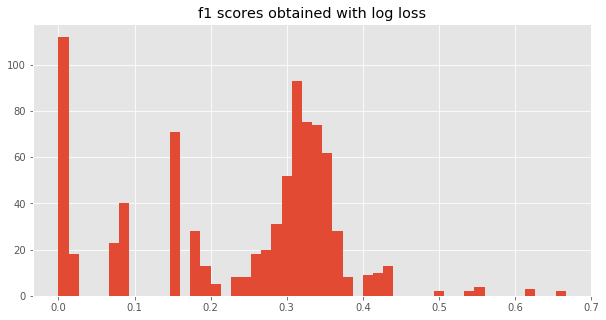

In [12]:
# dataset type 2

f1_achieved_log = []

for year in [1994+i for i in range(34)]:
    for tested_quarter in tq(year):
        
        # SGD with log loss
        
        SGDargs = {'class_weight':'balanced',
                   'random_state':42, 
                   'loss':'log', 
                   'max_iter':1000, 
                   'tol':0.1, 
                   'alpha':1e-5}
        
        f1_achieved_log.append(run(df,'2',year,tested_quarter,SGDargs))
            
        # also implement SGD with hinge loss
        
plt.figure(figsize=(10,5))
plt.hist(f1_achieved_log,bins=50)
plt.title('f1 scores obtained with log loss')